In [ ]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity,linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
%time datos = pd.read_csv('data_tokens.csv')

Wall time: 247 ms


In [ ]:
%time datos.tokens=datos.tokens.apply(literal_eval)

Wall time: 3.92 s


In [ ]:
conteo_categorias=datos['categorias'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
Admin,6515,33.688402,33.688402
Mylife,4459,23.057035,56.745437
Master Data Input,3611,18.672113,75.417550
Payroll,1898,9.814365,85.231915
Bswift,1075,5.558716,90.790630
OM (organizationa mgmt),514,2.657842,93.448472
Leaves,305,1.577124,95.025596
Year-End,197,1.018667,96.044263
Time,185,0.956616,97.000879
Systems NA,180,0.930762,97.931641


In [ ]:
datos.shape

(19339, 3)

In [ ]:
datos['distancias']=datos.tokens.apply(len)

In [ ]:
busqueda=tabla_categorias.query("acumulado<92").index # se selecciona el 92% de los datos 
datos['filtro']=datos.categorias.apply(lambda categoria: 1 if categoria in busqueda else 0) # se crea una variable filtro
filtro=datos.query("filtro==1").drop(columns=['filtro'])
datos.drop(columns=['filtro'],inplace=True)

<AxesSubplot:ylabel='Frequency'>

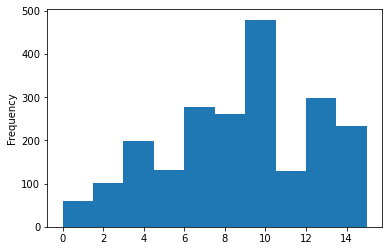

In [ ]:
filtro.query("distancias<=15").distancias.plot.hist()

In [ ]:
filtro.query("distancias<=7").categorias.value_counts()

Mylife               327
Master Data Input    200
Payroll              178
Bswift                43
Admin                 18
Name: categorias, dtype: int64

In [ ]:
tickets_cortos=filtro.query("distancias<=7").index
datos.drop(tickets_cortos,inplace=True)
pd.DataFrame(tickets_cortos,columns=['tickets_cortos']).to_csv('tickets_cortos.csv',index=False)

In [ ]:
tickets_cortos.shape

(766,)

In [ ]:
datos.shape

(18573, 4)

In [ ]:
datos.query("distancias<=7").categorias.value_counts()

OM (organizationa mgmt)    336
Leaves                      65
Year-End                    58
Interface Input             10
HR Request                   7
Systems NA                   5
Employee Request             3
Audit                        2
Time                         2
External Request             2
Name: categorias, dtype: int64

In [ ]:
conteo_categorias=datos['categorias'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
Admin,6497,34.980886,34.980886
Mylife,4132,22.247348,57.228235
Master Data Input,3411,18.365369,75.593604
Payroll,1720,9.260755,84.854358
Bswift,1032,5.556453,90.410811
OM (organizationa mgmt),514,2.767458,93.178270
Leaves,305,1.642169,94.820438
Year-End,197,1.060679,95.881118
Time,185,0.996070,96.877187
Systems NA,180,0.969149,97.846336


In [ ]:
# busqueda=tabla_categorias.query("acumulado<91").index
# datos['filtro']=datos.categorias.apply(lambda categoria: 1 if categoria in busqueda else 0)
# filtro=datos.query("filtro==1").index
# datos.drop(columns=['filtro'],inplace=True)

In [ ]:
%time fdist = nltk.FreqDist(np.concatenate(datos.reset_index(drop=True)['tokens']))
%time tokens=fdist.most_common(len(fdist))
%time tokens_tf=pd.DataFrame(tokens,columns=['token','TF'])

Wall time: 3.56 s
Wall time: 126 ms
Wall time: 229 ms


In [ ]:
tokens_tf.shape

(846416, 2)

In [ ]:
tokens_tf.query("TF>1",inplace=True)
tokens_tf.shape

(63539, 2)

In [ ]:
datos.etiquetas.value_counts()

1    6497
2    4132
3    3411
0    2813
4    1720
Name: etiquetas, dtype: int64

In [ ]:
query="TF<=6497 and TF>=172"
tokens_tf.query(query)

,token,TF
40,use,6411
41,mail,6301
42,need,6109
43,voltag,5868
44,attach,5768
...,...,...
1105,separ,173
1106,ltq,173
1107,efx,173
1108,high,173


<AxesSubplot:ylabel='Frequency'>

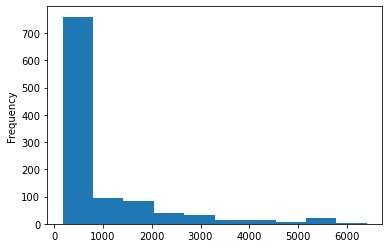

In [ ]:
tokens_tf.query(query).TF.plot.hist()

In [ ]:
bow = tokens_tf.query(query).token.values
bow.shape

(1070,)

In [ ]:
%time tfidf=pd.DataFrame(TfidfVectorizer(vocabulary=bow).fit_transform(datos['tokens'].str.join(" ")).toarray(), columns=bow)

Wall time: 1.79 s


In [ ]:
def obtener_similares(distancias):
    similares=set()
    for i in range(distancias.shape[0]):
        if i not in similares:
            similares.update((distancias[i]==1).nonzero()[0][1:])
    return list(similares)

In [ ]:
%time distancias_coseno=cosine_similarity(tfidf,tfidf)
similares_coseno=pd.Series(datos.index).loc[obtener_similares(distancias_coseno)].values

Wall time: 4.1 s


In [ ]:
busqueda=tabla_categorias.query("acumulado<91").index
similares_coseno_filtrados = []
for categoria in busqueda:
    similares_coseno_filtrados.extend(datos.loc[similares_coseno].query("categorias==@categoria").index)

In [ ]:
%time distancias_kernel=linear_kernel(tfidf,tfidf)
similares_kernel=pd.Series(datos.index).loc[obtener_similares(distancias_kernel)].values

Wall time: 4.07 s


In [ ]:
busqueda=tabla_categorias.query("acumulado<91").index
similares_kernel_filtrados = []
for categoria in busqueda:
    similares_kernel_filtrados.extend(datos.loc[similares_kernel].query("categorias==@categoria").index)

In [ ]:
len(similares_coseno_filtrados),len(similares_kernel_filtrados)

(2163, 1129)

In [ ]:
pd.DataFrame(similares_coseno_filtrados,columns=['similares']).to_csv('similares.csv',index=False)

In [ ]:
datos

,categorias,tokens,etiquetas,distancias
0,Mylife,"[arval, death, notifit, death, ssn, spous, not...",2,26
1,Mylife,"[retire, death, notif, benefit, pension, life,...",2,26
2,Admin,"[corpor, efax, messag, receiv, fax, est, refer...",1,63
3,Admin,"[corpor, efax, messag, spandsp, fax, ident, re...",1,66
4,Admin,"[corpor, efax, messag, spandsp, fax, ident, re...",1,66
...,...,...,...,...
19334,OM (organizationa mgmt),"[current, list, project, manag, need, move, ma...",0,9
19335,OM (organizationa mgmt),"[pleas, chang, posit, name, posit, electrician...",0,7
19336,OM (organizationa mgmt),"[updat, posit, reflect, float, manag, posit, n...",0,15
19337,OM (organizationa mgmt),"[updat, subgroup]",0,2


In [ ]:
datos.drop(index=similares_coseno_filtrados,inplace=True)

In [ ]:
conteo_categorias=datos['categorias'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
Admin,5312,32.370506,32.370506
Mylife,3743,22.809263,55.179768
Master Data Input,2932,17.867154,73.046923
Payroll,1637,9.975625,83.022547
Bswift,1005,6.124314,89.146862
OM (organizationa mgmt),514,3.132236,92.279098
Leaves,305,1.858623,94.137721
Year-End,197,1.200488,95.338208
Time,185,1.127361,96.465570
Systems NA,180,1.096892,97.562462


In [ ]:
conteo_categorias=datos['etiquetas'].value_counts()
tabla_categorias=pd.DataFrame()
tabla_categorias['conteo']=conteo_categorias
tabla_categorias['porcentaje']=(conteo_categorias/datos.shape[0]*100)
tabla_categorias['acumulado']=tabla_categorias['porcentaje'].cumsum()
tabla_categorias

,conteo,porcentaje,acumulado
1,5312,32.370506,32.370506
2,3743,22.809263,55.179768
3,2932,17.867154,73.046923
0,2786,16.977453,90.024375
4,1637,9.975625,100.000000
